# data proprecessing

In [ ]:
import os
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import multivelo as mv
import matplotlib.pyplot as plt
import gtvelo as gtv 

In [ ]:
cell_annot = pd.read_csv("D:\code\MultiVelo-main\Examples\cell_annotations.tsv", sep='\t', index_col=0)
adata_atac = sc.read_10x_mtx(r'D:\code\MultiVelo-main\outs\filtered_feature_bc_matrix', var_names='gene_symbols', cache=True, gex_only=False)
adata_atac = adata_atac[:,adata_atac.var['feature_types'] == "Peaks"]
adata_atac = mv.aggregate_peaks_10x(adata_atac,
                r"D:\minetool\e18_mouse_brain_fresh_5k_atac_peak_annotation.tsv",#???是这个网站上下的还是别的什么
                                    #r"D:\code\MultiVelo-main\test_files\peak_annotation.tsv",
                                    #r"D:\code\MultiVelo-main\test_files\feature_linkage.bedpe"
                                    r"D:\code\MultiVelo-main\outs\analysis\feature_linkage\feature_linkage.bedpe")
sc.pp.filter_cells(adata_atac, min_counts=2000)
sc.pp.filter_cells(adata_atac, max_counts=60000)
mv.tfidf_norm(adata_atac)
plt.hist(adata_atac.X.sum(1), bins=100, range=(0, 100000))

(3365, 936)

In [ ]:
shared_cells = pd.Index(np.intersect1d(adata_rna.obs_names, adata_atac.obs_names))
shared_genes = pd.Index(np.intersect1d(adata_rna.var_names, adata_atac.var_names))
len(shared_cells), len(shared_genes)
adata_rna = scv.read(r"D:\code\MultiVelo-main\Examples\velocyto\10X_multiome_mouse_brain.loom", cache=True)
adata_rna.obs_names = [x.split(':')[1][:-1] + '-1' for x in adata_rna.obs_names]
adata_rna.var_names_make_unique()
adata_rna = adata_rna[shared_cells, shared_genes]
adata_atac = adata_atac[shared_cells, shared_genes]
scv.pp.normalize_per_cell(adata_rna)
scv.pp.log1p(adata_rna)
#scv.pp.moments(adata_rna, n_pcs=30, n_neighbors=50)


In [ ]:
adata_rna.obs['celltype'] = cell_annot.loc[adata_rna.obs_names, 'celltype']
adata_rna.obs['celltype'] = adata_rna.obs['celltype'].astype('category')
all_clusters = ['Upper Layer',
                'Deeper Layer',
                'V-SVZ',
                'RG, Astro, OPC',
                'Ependymal cells',
                'IPC',
                'Subplate']
adata_rna.obs['celltype'] = adata_rna.obs['celltype'].cat.reorder_categories(all_clusters)


In [ ]:
nn_idx = np.loadtxt(r"D:\code\MultiVelo-main\outs\nn_idx.txt", delimiter=',')
nn_dist = np.loadtxt(r"D:\code\MultiVelo-main\test_files\nn_dist.txt", delimiter=',')
nn_cells = pd.Index(pd.read_csv(r"D:\code\MultiVelo-main\outs\nn_cells.txt", header=None)[0])

# Make sure cell names match.
np.all(nn_cells == adata_atac.obs_names)
mv.knn_smooth_chrom(adata_atac, nn_idx, nn_dist)

True

In [ ]:
adata_atac.write(r'D:\code\mine\test_data\atac_u_s\10x_mousebrain_atac.h5ad')
adata_rna.write(r'D:\code\mine\test_data\atac_u_s\10x_mousebrain_rna.h5ad')

In [ ]:
adata = adata_rna
adata.layers['Mc'] = adata_atac.layers['Mc']
adata.layers['atac_nosmooth'] = adata_atac.X
adata.obsp['connectivities'] = adata_atac.obsp['connectivities']
adata = gtv.utils.atac_clean_recipe(adata_rna, spliced_key='spliced', unspliced_key='unspliced',
                            umap=False, log=True, n_neighbors=50, 
                            connectivities = adata_atac.obsp['connectivities'])                          

Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
adata=sc.read(r'D:\code\mine\finish\latentvelo\lat_adata_latent\10x_mousebrain_adata.h5ad')
adata

AnnData object with n_obs × n_vars = 3365 × 936
    obs: 'n_counts', 'celltype', 'spliced_size_factor', 'unspliced_size_factor', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'batch_id', 'celltype_id', 'root', 'terminal'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'velocity_genes'
    uns: 'log1p', 'neighbors', 'pca', 'scale_spliced', 'scale_unspliced'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'Mc', 'Ms', 'Mu', 'ambiguous', 'atac', 'atac_nosmooth', 'mask_spliced', 'mask_unspliced', 'matrix', 'spliced', 'spliced_counts', 'spliced_raw', 'unspliced', 'unspliced_counts', 'unspliced_raw'
    obsp: 'adj', 'connectivities', 'distances'

In [ ]:
model = gtv.models.ATACRegModel(observed=936, latent_dim=20, zr_dim=2, h_dim=2)
epochs, val_ae, val_traj = gtv.train_atac(model, adata, batch_size = 100,
                                      epochs=50, name='mouse_brain', grad_clip=1000)

735 velocity genes used
epoch 0, full loss 443.237, val loss 1034.327, recon 3.906, traj 39.500, velo -1.250
epoch 1, full loss 217.689, val loss 340.791, recon 2.640, traj 33.416, velo -1.016
epoch 2, full loss 61.176, val loss 139.674, recon 2.658, traj 38.134, velo -1.163
epoch 3, full loss -82.274, val loss -16.311, recon 2.954, traj 33.167, velo -1.377
epoch 4, full loss -169.897, val loss -113.173, recon 2.477, traj 29.504, velo -1.544
epoch 5, full loss -244.018, val loss -168.748, recon 2.496, traj 24.545, velo -1.598
epoch 6, full loss -311.497, val loss -270.711, recon 2.141, traj 21.955, velo -1.218
epoch 7, full loss -333.535, val loss -317.259, recon 2.148, traj 21.668, velo -0.716
epoch 8, full loss -365.193, val loss -338.212, recon 1.953, traj 20.959, velo -0.334
epoch 9, full loss -384.449, val loss -362.013, recon 1.767, traj 20.925, velo -1.057
epoch 10, full loss -411.751, val loss -382.657, recon 1.541, traj 20.478, velo -0.494
epoch 11, full loss -426.176, val los

KeyError: 'X_umap'

# FIG5 A

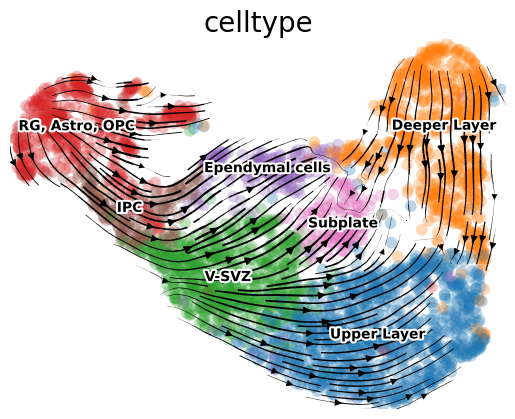

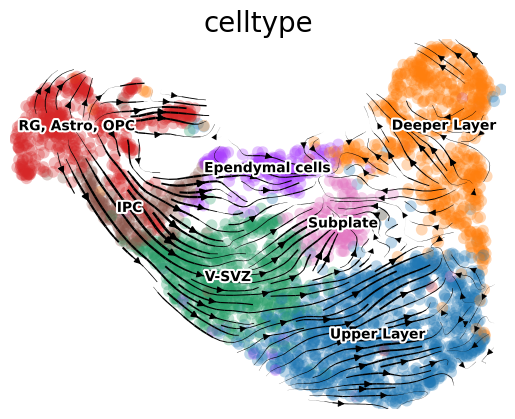

In [1]:

import scanpy as sc 
import scvelo as scv 
latent_adata=sc.read_h5ad(r'D:\code\mine\GTvelo\1_adata_latentadata\10x_mousebrainfina_latent_adata.h5ad')
m_mb_adata=sc.read_h5ad(r"D:\code\MultiVelo-main\HSS\multivelo_mouse brain_adata2.h5ad")
scv.pl.velocity_embedding_stream(latent_adata,vkey='spliced_velocity',basis='umap', color=['celltype'],#dpi=300,save='D:/重要文件/小论文/图片/fig5/A1.png',title='GTVelo',    legend_fontsize=14, 
    legend_fontoutline=3 ,
    fontsize=20)
scv.pl.velocity_embedding_stream(m_mb_adata,vkey='velo_s', basis='umap',color=['celltype'],#dpi=300,save='D:/重要文件/小论文/图片/fig5/A2.png',title='MultiVelo',    legend_fontsize=14, 
    legend_fontoutline=3 ,
    fontsize=20)


# FIG5  B C

In [ ]:
import scanpy as sc 
import scvelo as scv 
#latent_adata=sc.read_h5ad(r'D:\code\mine\GTvelo\1_adata_latentadata\10x_mousebrainfina_latent_adata.h5ad')
adata=sc.read_h5ad(r'D:\code\mine\GTvelo\1_adata_latentadata\10x_mousebrainfina_adata.h5ad')
genes_to_analyze=['Pax6' ,'Sox9','Dlx1' ]
scv.tl.recover_dynamics(adata,n_jobs= 12)
scv.tl.latent_time(adata,vkey='velo_s')


recovering dynamics (using 12/28 cores)


  0%|          | 0/735 [00:00<?, ?gene/s]

    finished (0:01:31) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [ ]:
genes_to_analyze=['Pax6' ,'Sox9','Dlx1' ]

Successfully analyzed Pax6
Successfully analyzed Sox9
Successfully analyzed Dlx1


Successfully analyzed Pax6 with enhanced DTW
Successfully analyzed Sox9 with enhanced DTW
Successfully analyzed Dlx1 with enhanced DTW


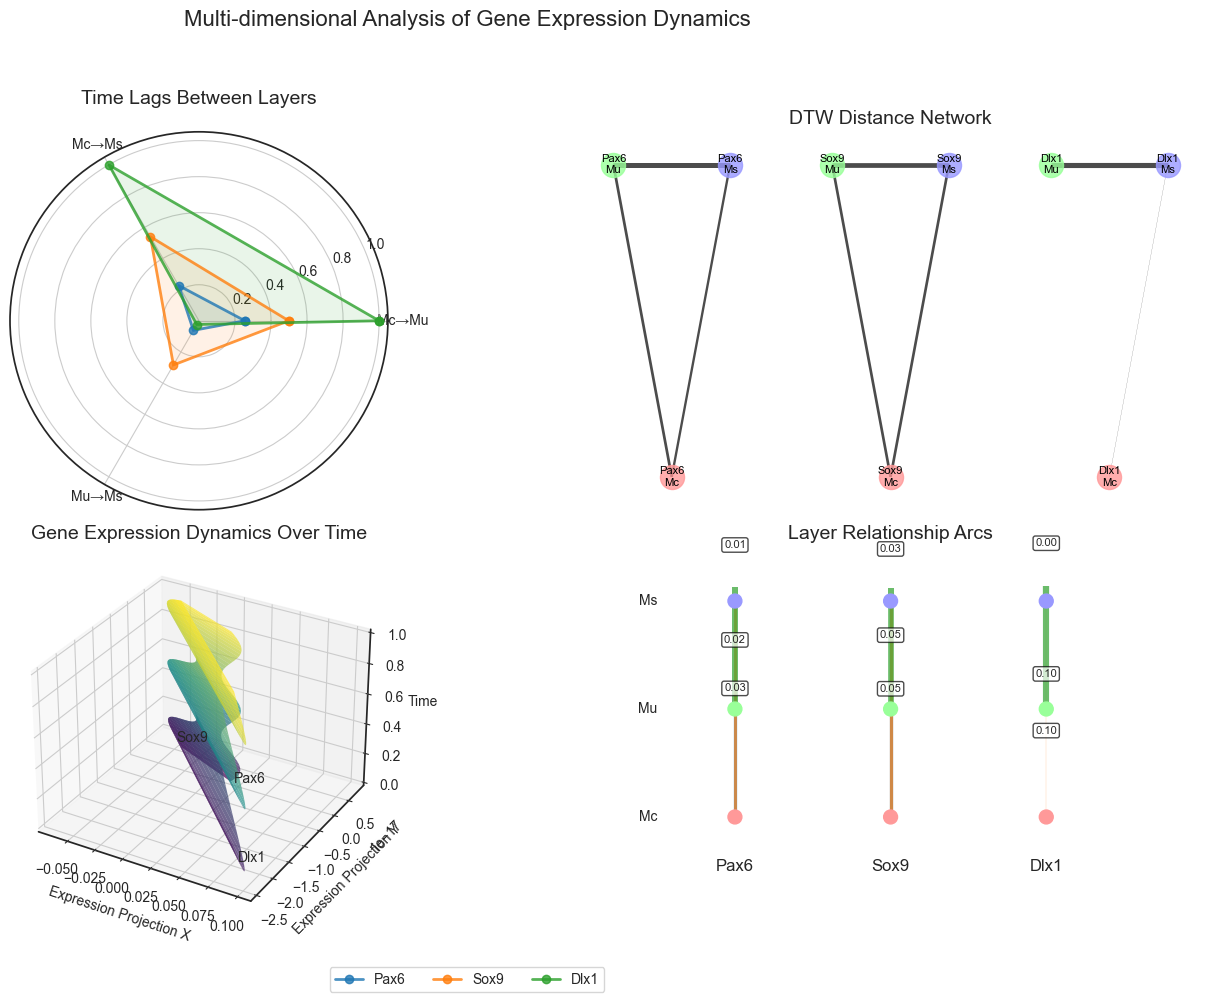

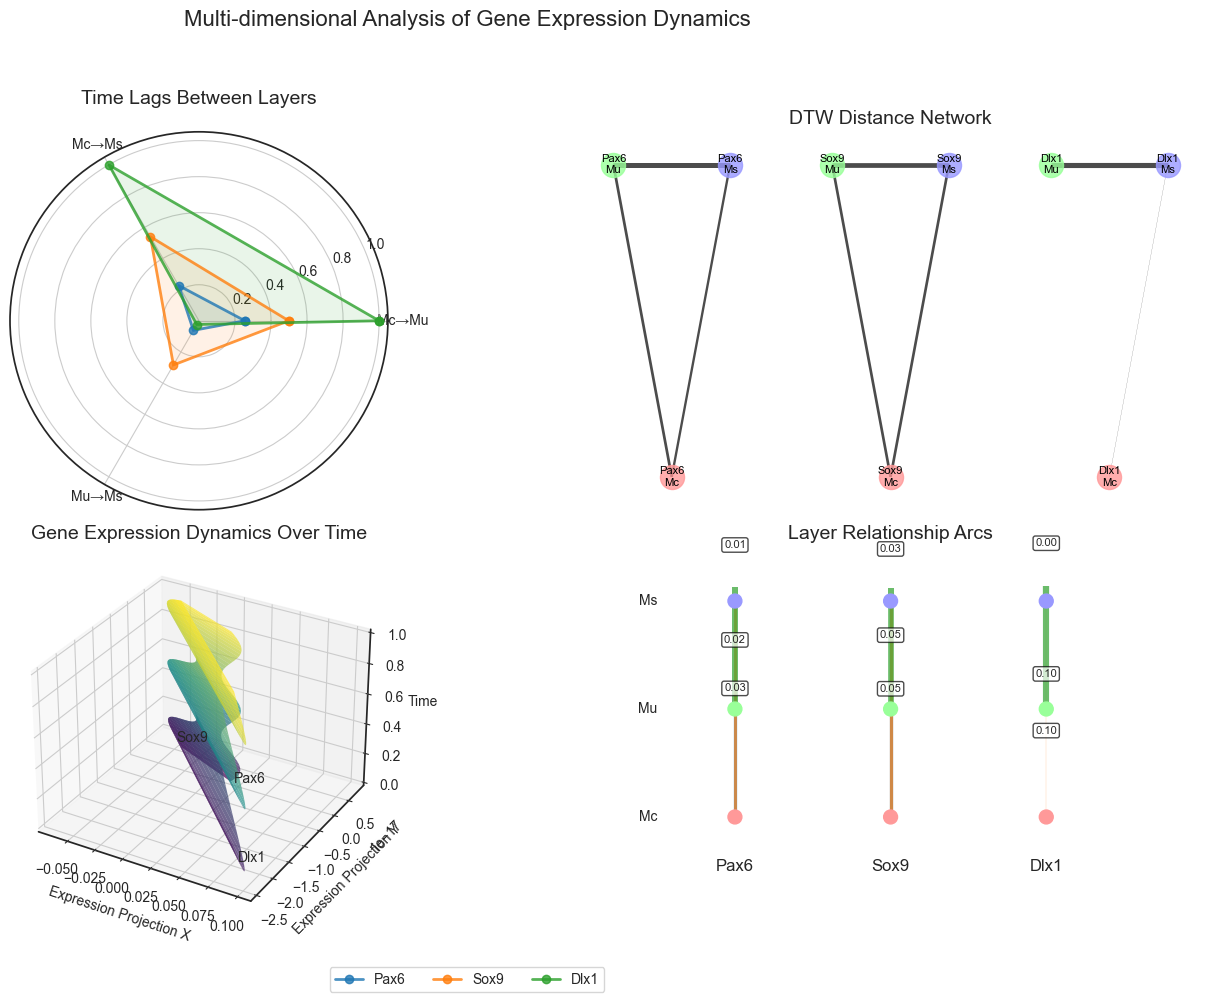

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
 

# Alternative DTW calculation with enhanced features
def enhanced_dtw_analysis(adata, gene, layers=['Mc', 'Mu', 'Ms'], window=None, step_pattern="symmetric2"):
    """
    Enhanced Dynamic Time Warping (DTW) analysis with additional features
    
    Parameters:
    -----------
    adata : AnnData
        Annotated data matrix
    gene : str
        Gene name to analyze
    layers : list
        Layers to compare (chromosome accessibility, unspliced, spliced)
    window : int or None
        Window size constraint for DTW calculation (None = no constraint)
    step_pattern : str
        DTW step pattern ("symmetric1", "symmetric2", "asymmetric", etc.)
        
    Returns:
    --------
    dict of enhanced DTW results and metrics
    """
    # Sort data by latent time
    sorted_indices = np.argsort(adata.obs['latent_time'])
    sorted_time = adata.obs['latent_time'][sorted_indices].values
    
    # Extract data for the gene across different layers
    layer_data = {}
    for layer in layers:
        # Convert to dense array and flatten
        layer_data[layer] = adata[sorted_indices, gene].layers[layer].toarray().flatten()
    
    # Perform enhanced DTW between different layers
    dtw_results = {}
    time_lags = {}
    feature_metrics = {}
    
    # Compare all possible pairs of layers
    layer_pairs = [
        ('Mc', 'Mu'),  # Chromatin & Unspliced
        ('Mc', 'Ms'),  # Chromatin & Spliced
        ('Mu', 'Ms')   # Unspliced & Spliced
    ]
    
    for layer1, layer2 in layer_pairs:
        # Manual normalization for sparse matrices
        x = layer_data[layer1]
        y = layer_data[layer2]
        
        # Apply smoothing for noise reduction
        x_smooth = smooth_signal(x, window_len=5)
        y_smooth = smooth_signal(y, window_len=5)
        
        # Normalize using numpy methods
        x_norm = (x_smooth - np.mean(x_smooth)) / (np.std(x_smooth) if np.std(x_smooth) > 0 else 1)
        y_norm = (y_smooth - np.mean(y_smooth)) / (np.std(y_smooth) if np.std(y_smooth) > 0 else 1)
        
        # Perform DTW with advanced options
        distance = dtw.distance(x_norm, y_norm, window=window)
        path = dtw.warping_path(x_norm, y_norm, window=window)
        
        # Calculate improved time lag - weighted by signal intensity
        weights = np.array([x_norm[p[0]] * y_norm[p[1]] for p in path])
        if np.sum(abs(weights)) > 0:
            weights = abs(weights) / np.sum(abs(weights))
        else:
            weights = np.ones(len(path)) / len(path)
            
        time_lag = np.sum([
            abs(sorted_time[p[0]] - sorted_time[p[1]]) * weights[i]
            for i, p in enumerate(path)
        ])
        
        time_lags[f'{layer1}_to_{layer2}'] = time_lag
        
        # Calculate additional feature metrics
        feature_metrics[f'{layer1}_to_{layer2}'] = {
            'correlation': np.corrcoef(x_norm, y_norm)[0, 1],
            'peak_shift': calculate_peak_shift(x_norm, y_norm),
            'complexity': calculate_complexity(path),
            'path_deviation': calculate_path_deviation(path)
        }
        
        dtw_results[f'{layer1}_to_{layer2}'] = {
            'distance': distance,
            'path': path,
            'normalized_distance': distance / len(path)
        }
    
    return {
        'dtw_results': dtw_results,
        'time_lags': time_lags,
        'feature_metrics': feature_metrics
    }

def smooth_signal(x, window_len=5, window='hanning'):
    """Smooth the data using a window with requested size."""
    if window_len < 3:
        return x
    
    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    
    if window == 'flat':  # moving average
        w = np.ones(window_len, 'd')
    else:
        w = getattr(np, window)(window_len)
    
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[(window_len//2):-(window_len//2)]

def calculate_peak_shift(x, y):
    """Calculate the shift between signal peaks."""
    x_peak = np.argmax(x)
    y_peak = np.argmax(y)
    return abs(x_peak - y_peak)

def calculate_complexity(path):
    """Calculate path complexity based on deviation from diagonal."""
    return np.mean([abs(p[0] - p[1]) for p in path])

def calculate_path_deviation(path):
    """Calculate how much the path deviates from a direct diagonal path."""
    diagonal = np.linspace(0, len(path)-1, len(path))
    actual = np.array([abs(p[0] - p[1]) for p in path])
    return np.sum(abs(actual - diagonal)) / len(path)

# Function to batch analyze genes with enhanced DTW
def enhanced_analyze_gene_dynamics(adata, genes, **kwargs):
    """
    Analyze dynamics for multiple genes using enhanced DTW
    """
    results = {}
    for gene in genes:
        try:
            results[gene] = enhanced_dtw_analysis(adata, gene, **kwargs)
            print(f"Successfully analyzed {gene} with enhanced DTW")
        except Exception as e:
            print(f"Error analyzing {gene}: {e}")
    return results

# Example usage:
enhanced_results = enhanced_analyze_gene_dynamics(adata, genes_to_analyze)
#visualize_dtw_dynamics(enhanced_results)#output_file="gene_dynamics_visualization.png")

# FIG5 D E

Starting dynamic_plot...


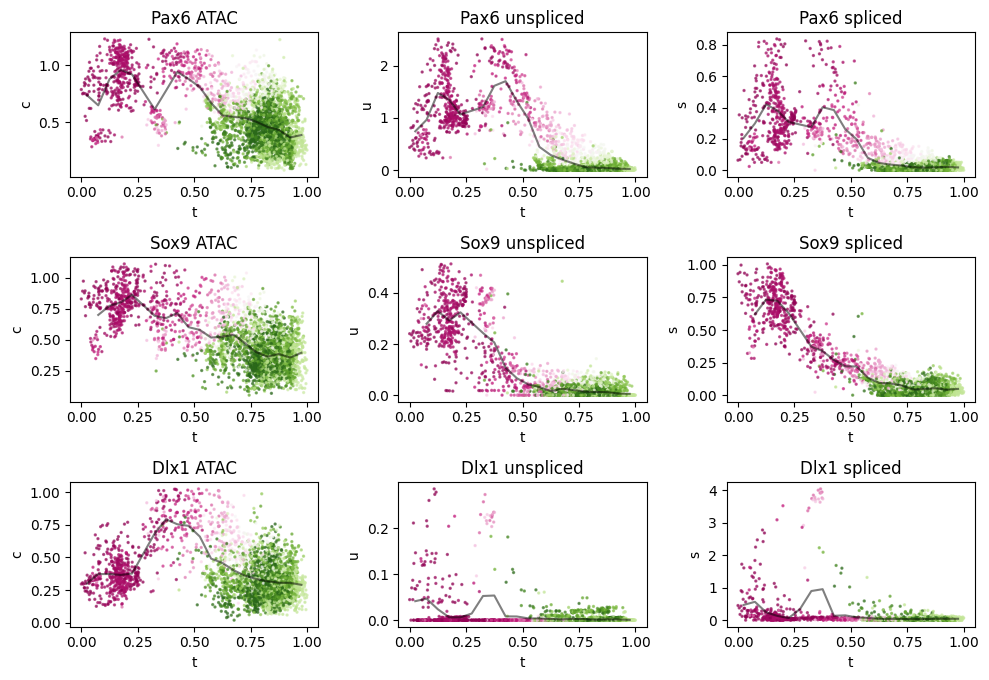

In [ ]:
cmap3 = plt.get_cmap('PiYG')

# 调用 mv.dynamic_plot，并传入自定义 colormap
mv.dynamic_plot(
    adata,
    genes=genelist,
    by='expression',  # 或 'velocity'
    color_by='velo_s',  # 使用你已有的分类数据替代'state'
    show_anchors=False,  # 因为没有anchor数据
    show_switches=False,  # 因为没有switch time数据
    gene_time=False,  # 你有fit_t数据
    cmap=cmap3,
    #axis_on=False,  # 默认改为False来隐藏坐标轴
    #frame_on=False,
 
)
plt.savefig('D:/重要文件/小论文/图片/fig5/D_separate2.png', dpi=300, bbox_inches='tight')


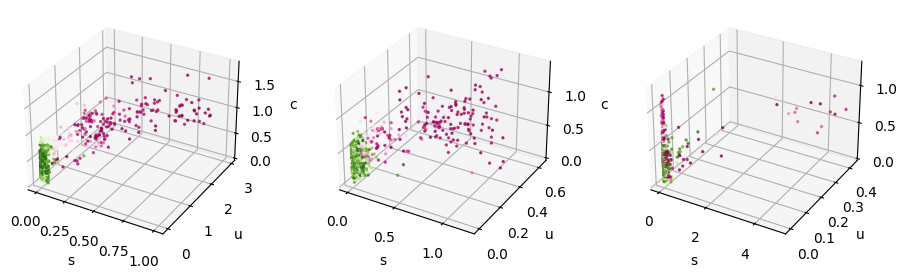

In [ ]:

#cmap3 = plt.get_cmap('twilight_shifted')
mv.scatter_plot(adata, by='cus', n_cols=3, color_by='velo_s', downsample=4, show_anchors=False, genes=genelist,cmap=cmap3)

plt.savefig('D:/重要文件/小论文/图片/fig5/E_3D.png', dpi=300, bbox_inches='tight')
 